In [1]:
from utils.binaries import *
from utils.plotting import *
from utils.auger.fd import XYScanner
from utils.auger.fd import get_mirror_or_telescope
from utils import CONSTANTS

19:23:00 (   +9.2s) [INFO   ] -- import logging


19:23:00 (  +136ms) [INFO   ] -- import numpy as np
19:23:00 (    +6ms) [INFO   ] -- import uncertainties
19:23:00 (    +6ms) [INFO   ] -- import uncertainties
19:23:00 (  +313ms) [INFO   ] -- import pandas as pd
19:23:00 (    +1ms) [WARNING] -- pandas support to be dropped at some point!
19:23:00 (    +1ms) [INFO   ] -- import binaries.tools as tools
19:23:01 (  +379ms) [INFO   ] -- import matplotlib.pyplot as plt
19:23:01 (  +555ms) [INFO   ] -- import seaborn as so
19:23:01 (    +3ms) [INFO   ] -- set MONI_PATH = PosixPath('/home/filip/Data/monit_and_sd')
19:23:01 (    +0ms) [INFO   ] -- set HIST_PATH = PosixPath('/home/filip/Data/monit_and_sd')
19:23:01 (    +1ms) [INFO   ] -- set PLOT_PATH = PosixPath('/home/filip/Data/plots')
19:23:01 (    +0ms) [INFO   ] -- set DATA_PATH = PosixPath('/home/filip/Data')
19:23:01 (    +1ms) [INFO   ] -- set SCAN_PATH = PosixPath('/home/filip/Public/xy-calibration')
19:23:01 (    +0ms) [INFO   ] -- set OFLN_PATH = PosixPath('/home/filip/Public/offl

In [2]:
from collections import defaultdict
all_data = defaultdict(dict)
camera_drifts = [[] for _ in range(5)]
for (year, month) in [[2024,11], [2023,11], [2023,10], [2022,10]]:
    campaign = XYScanner.Campaign(year, month)

    for run in campaign:
        calA_mean = np.zeros(440)
        for r in ['preXY', 'postXY']:
            data = np.loadtxt(CONSTANTS.SCAN_PATH / f"results/out_{run[r]}.txt", usecols=2)
            mirror_index = (int(get_mirror_or_telescope(run.telescope)[1:])-1) // 6
            if r == 'postXY':
                drift = (data - 2*calA_mean) / data
                d = np.abs(drift - np.median(drift))
                mdev = np.median(d)
                s = d/mdev if mdev else np.zeros(len(d))
                camera_drifts[mirror_index] += list(drift[s<3])
            calA_mean += 0.5 * data
        this_data = run.xy / calA_mean

        if run.year_and_month == "2024-12": run.year_and_month = "2024-11"
        all_data[run.telescope][run.year_and_month] = this_data

Text(0.5, 0, '(preXY - postXY) / preXY')

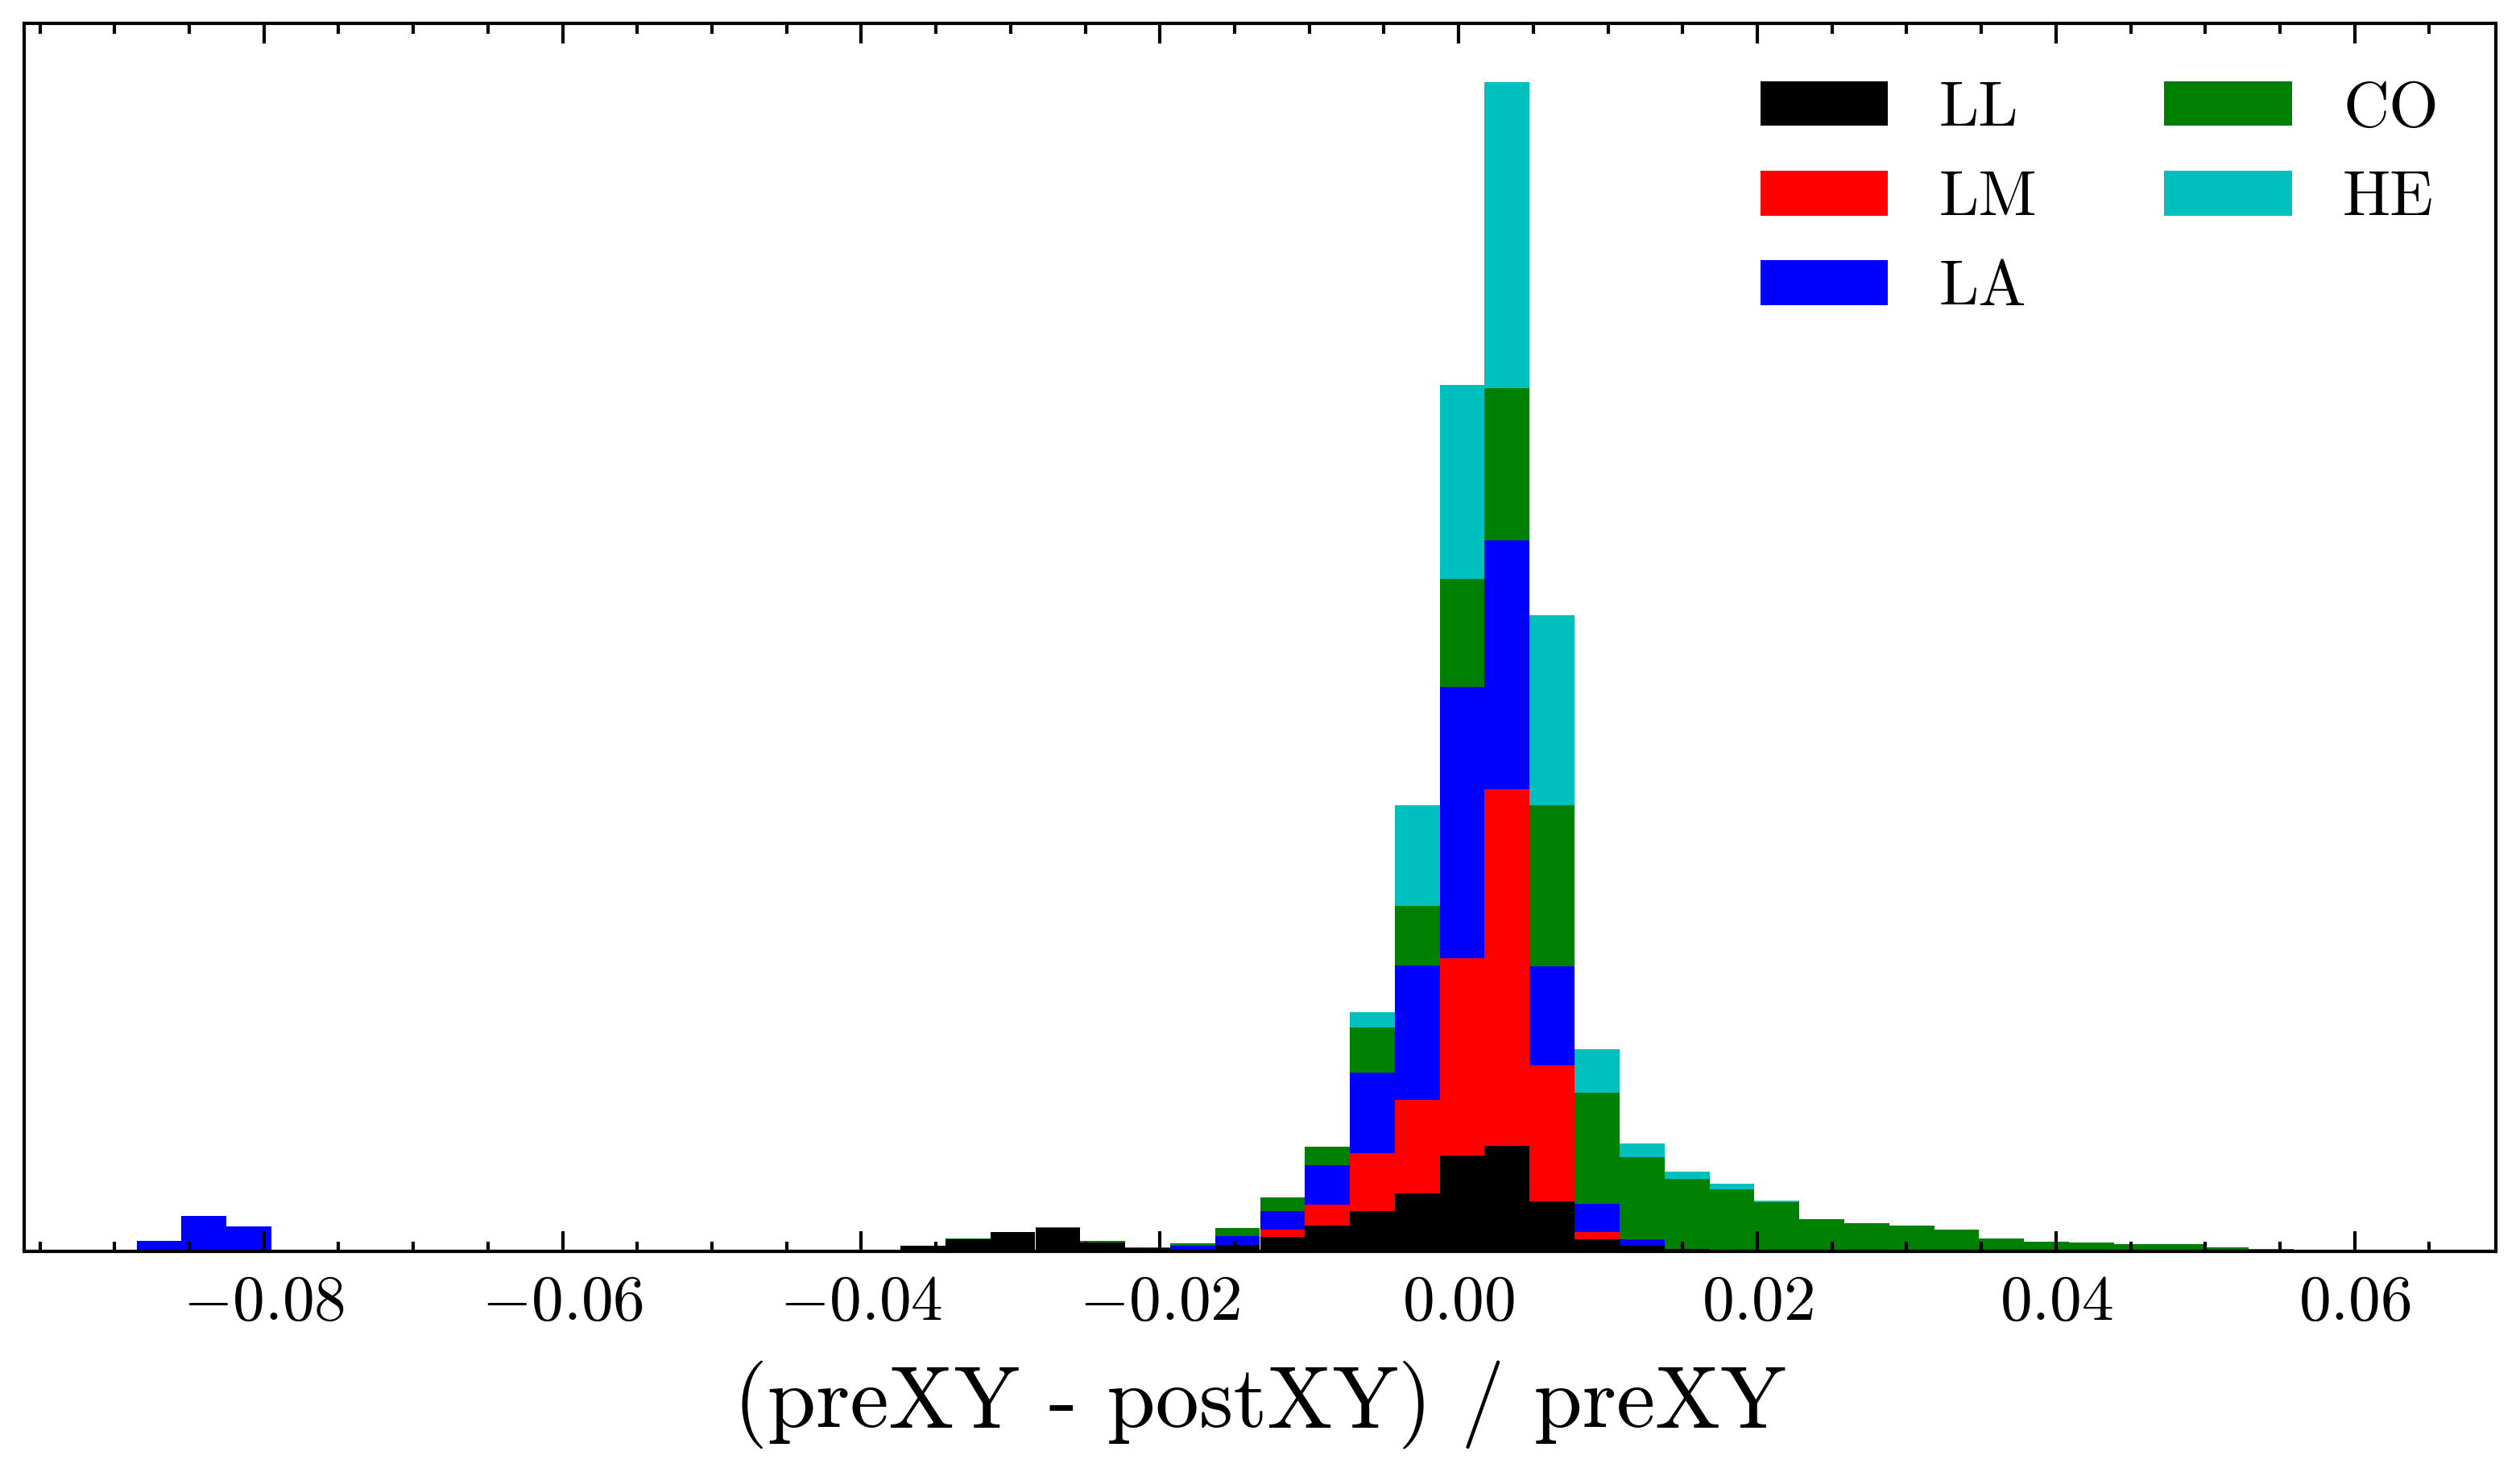

In [3]:
_ = plt.hist(camera_drifts, histtype='barstacked', bins=50, label=['LL', 'LM', 'LA', 'CO', 'HE'])
plt.yticks([])
plt.legend(ncol=2)
plt.xlabel("(preXY - postXY) / preXY")

In [4]:
from matplotlib.gridspec import GridSpec
from datetime import datetime, timedelta
from matplotlib.colors import Normalize
from matplotlib.colors import BoundaryNorm
from matplotlib.cm import ScalarMappable

# def calculate_color(date):

#     cmap = plt.cm.viridis
#     min, max = datetime(2019, 11, 1), datetime(2024, 11, 1)
#     date = datetime.strptime(date, "%Y-%m")
#     _range = (max - min).total_seconds()
#     _x = (date - min).total_seconds()

#     return CMAP(_x / _range)

# def calculate_date(tick, _):
#     min, max = datetime(2022, 10, 1), datetime(2024, 11, 1)
#     _range = (max - min).total_seconds()
#     return datetime.strftime(min + timedelta(seconds=tick * _range), "%y/%m")

_range = {
    "HE" : (7e-9, 8e-7),
    "CO" : (3e-7, 1.8e-6),
    "LA" : (3e-7, 1.5e-6),
    "LM" : (3e-7, 1.4e-6),
    "LL" : (4e-7, 1.8e-6),
}

i = {"2022-10": 0, "2023-10": 1, "2023-11": 2, "2024-11": 3}
CMAP = plot.gradient(plt.cm.viridis, 4)

for (j, tel) in enumerate(["HE", "CO", "LA", "LM", "LL"]):
    # if tel != "LL": continue

    match tel:
        case "HE":
            tel_number = 3
        # case "ll":
        #     tel_number = 5
        case _:
            tel_number = 6

    fig = plt.figure()
    gs = GridSpec(tel_number, 2, fig, hspace=-0.3, wspace=0.01, width_ratios=[1, 0.04])

    axes = [fig.add_subplot(gs[i, 0]) for i in range(tel_number)]
    cax = fig.add_subplot(gs[:, 1])

    spines = ["top", "right", "left", "bottom"]
    for k, ax in enumerate(axes, 1):
        for s in spines:
            ax.spines[s].set_visible(False)
        # ax.set_ylim(0)
        ax.patch.set_alpha(0)
        ax.set_yticks([])
        ax.set_xticks([])
        ax.axhline(0, c="k", zorder=10)
        ax.text(
                0.99,
                0.04,
                f"{tel}{k}",
                transform=ax.transAxes,
                ha="right",
                va="bottom",
            )
    
    ax.set_xlabel(r"(Cal XY corr. / CalA EventSum) / $\frac{\gamma}{\mathrm{ADC}^{2}}$")
    norm = BoundaryNorm(np.arange(-0.5, 4.5, 1), plt.cm.viridis.N)
    mappable = ScalarMappable(norm, plt.cm.viridis)
    plt.colorbar(mappable, cax=cax, label="DAQ time")
    cax.set_yticks(
        [0, 1, 2, 3],
        ["Oct 22", "Oct 23", "Nov 23", "Nov 24"],
        rotation=90,
        va="center",
    )
    # cax.yaxis.set_major_formatter(calculate_date)
    # plt.setp( cax.yaxis.get_majorticklabels(), rotation=-15)

    # ax.set_xlabel(r"Cal XY corr. / std. Cal")

    for telescope in all_data.keys():
        if tel not in telescope: continue
        ax = axes[int(telescope[-1])-1]

        if telescope in ['LL1', 'LL6']:
            addon = "" if telescope == 'LL1' else "-xp3062"
            mask = np.loadtxt(CONSTANTS.SCAN_PATH 
                              / f"config/pixel_masks/{telescope.lower()}{addon}.txt", usecols=[-1], dtype=bool)
        else:
            mask = np.ones(440, dtype=bool)

        for date, ratio in all_data[telescope].items():
            color = CMAP[i[date]]
            X = np.linspace(*_range[tel], 10000)
            Y = tools.kd1d_estimate(ratio[mask], bandwidth=4e-8)(X)
            ax.plot(X, Y, c="w", marker="none", ls="solid", lw=0.4, zorder=i[date])
            fill = ax.fill_between(X, Y, alpha=0.9, color=color, ec="none")

    plot.save(fig, f"xy_telescope_drift/{tel}_gain_corrected")
    plt.close(fig)

In [ ]:
from pathlib import Path
from utils.auger.fd import PixelPlot

# save median/mean to file
save_path = Path(CONSTANTS.DATA_PATH / "xy_pixel_medians")
save_path.mkdir(exist_ok=True, parents=True)

for tel, runs in all_data.items():
    match tel:
        case 'LL1':
            mask = np.loadtxt(CONSTANTS.SCAN_PATH / "config/pixel_masks/ll1.txt", usecols=-1, dtype=bool)
        case 'LL6':
            mask = np.loadtxt(CONSTANTS.SCAN_PATH / "config/pixel_masks/ll6-xp3062.txt", usecols=-1, dtype=bool)
        case _:
            mask = np.ones(440, dtype=bool)

    norm, mean = len(runs), np.zeros(440)
    for run in runs.values():
        mean += run/norm

    mean[~mask] = np.nan

    np.savetxt(save_path / f"{tel}.txt", mean)
    PixelPlot(mean)
    plt.savefig(save_path / f"{tel}.png")
    plt.close(plt.gcf())
    

In [ ]:
from utils.binaries import *
from utils.plotting import *
from utils.auger.fd import XYScanner
from utils.auger.fd import get_mirror_or_telescope
from utils import CONSTANTS

for (year, month) in [[2024,11], [2023,11], [2023,10], [2022,10], [2019,11]]:
    campaign = XYScanner.Campaign(year, month)
    fig = campaign.summary(ymin=0.6, ymax=1.4, normalize='cala', cala_drift=0.02)
    plot.save(fig, f"xy_campaign_summary/{year}_{month}_2percent_drift.png")
    plt.close(fig)